# 头文件导入  

In [1]:
import torch
import torchvision
import torchsummary
import os
import time
import numpy as np
import matplotlib.pyplot as plt

# 常量定义  

In [2]:
TRANSFORM = torchvision.transforms.Compose(
    [
     #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     torchvision.transforms.ToTensor()
    ])
BATCH_SIZE = 4
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


# 数据集导入  
## 官方数据集导入  

In [3]:
TRAINDATASETS = torchvision.datasets.CIFAR10(root='../datasets/CIFAR', train=True,
                                        download=True, transform=TRANSFORM)
TRAINLOADER = torch.utils.data.DataLoader(TRAINDATASETS, batch_size=BATCH_SIZE,
                                          shuffle=True)

TESTDATASETS = torchvision.datasets.CIFAR10(root='../datasets/CIFAR', train=False,
                                       download=True, transform=TRANSFORM)
TESTLOADER = torch.utils.data.DataLoader(TESTDATASETS, batch_size=BATCH_SIZE,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


TRAINDATASETS[?] 返回值为 data,label  
data形状为[3,32,32] ([c,h,w])的张量 label数值为int  
plt.imshow 需要传入[h,w,c] 所以通过 np.transpose 将通道调整  

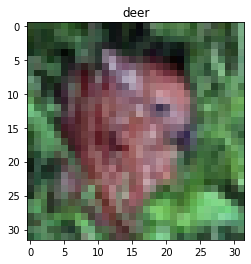

In [4]:
_ = np.random.randint(0,len(TRAINDATASETS))
img,label = TRAINDATASETS[_]
img = np.transpose(img,(1,2,0))
plt.title(CLASSES[label])
plt.imshow(img)

## 自建数据集  

CIFAR10 共有是10类文件 

| 英文 | 中文 | 标签 |
| ---  | --- | --- |
| airplane | 飞机 | 0 |
| automobile | 汽车 | 1 |
| bird | 鸟 | 2 |
| cat | 猫 | 3 |
| deer | 鹿 | 4 |
| dog | 狗 | 5 |
| frog | 青蛙 | 6 |
| horse | 马 | 7 |
| ship | 船 | 8 |
| truk | 卡车 | 9 |

官方数据集文件每类6000张共60000张  
测试集10000张，训练集50000张  
每张图片为3通道32X32像素图片  
官方提供文件代码解析函数为  
```python
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
```
如果传入为对应数据则返回值为词典  
b'batch_label':无用  
b'labels':对应label  
b'data':np.array数据类型,形状为(N,3*32*32),每个数据为1024(R)+1024(G)+1024(B)  
b'filenames':文件路径  

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
class MyDataSets(torch.utils.data.Dataset):
    def __init__(self,train=True,transform=None):
        super(MyDataSets,self).__init__()
        self.train = train
        self.transform = transform
        self.data,self.labels = [],[]
        if self.train:
            for i in range(1,6):
                temp = unpickle("../datasets/CIFAR/cifar-10-batches-py/data_batch_{}".format(i))
                self.data = self.data + ([np.transpose( x.reshape((3,32,32)),(1, 2, 0)) for x in temp[b'data']  ])
                self.labels = self.labels + temp[b'labels']
        else:
            temp = unpickle("../datasets/CIFAR/cifar-10-batches-py/test_batch")
            self.data = self.data + ([np.transpose( x.reshape((3,32,32)),(1, 2, 0)) for x in temp[b'data']  ])
            self.labels = self.labels + temp[b'labels']
        self.data = np.array(self.data,dtype=np.uint8)
        self.labels = np.array(self.labels,dtype=np.int64)
    def __getitem__(self,idx):
        data,label = self.data[idx],self.labels[idx]
        data = self.transform(data)
        return data,label
    def __len__(self):
        return len(self.labels)

In [7]:
TRAINDATASETS = MyDataSets(train=True,transform=TRANSFORM)
TRAINLOADER = torch.utils.data.DataLoader(TRAINDATASETS, batch_size=BATCH_SIZE,
                                          shuffle=True)

TESTDATASETS = MyDataSets(train=False, transform=TRANSFORM)
TESTLOADER = torch.utils.data.DataLoader(TESTDATASETS, batch_size=BATCH_SIZE,
                                         shuffle=False)

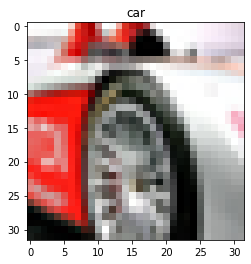

In [8]:
_ = np.random.randint(0,len(TRAINDATASETS))
img,label = TRAINDATASETS[_]
img = np.transpose(img,(1,2,0))
plt.title(CLASSES[label])
plt.imshow(img)

# 网络搭建

In [18]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = Net()
model.to(DEVICE)
torchsummary.summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [22]:
model = torchvision.models.resnet18(True)
model.fc=torch.nn.Sequential(
    torch.nn.Linear(512,1000),
    torch.nn.Linear(1000,10))
model.to(DEVICE)
torchsummary.summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

# 模型训练

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:
import sys

for epoch in range(2):
    start_time = time.perf_counter()
    model.train()
    running_loss = 0.0
    for batch_idx,data in enumerate(TRAINLOADER):
        inputs,target = data
        inputs,target = inputs.to(DEVICE),target.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        #target = target.squeeze()
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 50 == 49:
            sys.stdout.write("epoch:{:2d}\t {}\t:{:.2%}\t loss:{:.2f}\t\r".format(epoch,"train",(batch_idx+1)/len(TRAINLOADER),running_loss/(batch_idx+1)))
            sys.stdout.flush()
    sys.stdout.write('\n')
    sys.stdout.flush()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx,data in enumerate(TESTLOADER):
            inputs,target = data
            inputs,target = inputs.to(DEVICE),target.to(DEVICE)
            outputs = model(inputs)
            #target = target.squeeze()
            _,predict = torch.max(outputs.data,dim=1)
            total += target.size(0)
            correct += (predict == target).sum().item()
            if batch_idx % 50 == 49:
                sys.stdout.write("epoch:{:2d}\t {}\t:{:.2%}\t accuracy:{:.2%}\t\r".format(epoch,"test",(batch_idx+1)/len(TESTLOADER),correct/total))
                sys.stdout.flush()
        sys.stdout.write('\n')
        sys.stdout.flush()
    end_time = time.perf_counter()
    print("epoch {} time: is {:.3f}s".format(epoch,end_time-start_time))

epoch: 0	 train	:100.00%	 loss:1.70	
epoch: 0	 test	:100.00%	 accuracy:59.20%	
epoch 0 time: is 388.793s
epoch: 1	 train	:100.00%	 loss:1.36	
epoch: 1	 test	:100.00%	 accuracy:65.48%	
epoch 1 time: is 389.530s


# 结果测试

tensor([[-5.7256, -4.2241,  9.9137, -0.2976,  4.4520,  4.2210,  6.8563, -0.5643,
         -9.1874, -5.4846]], device='cuda:0')
dog : False


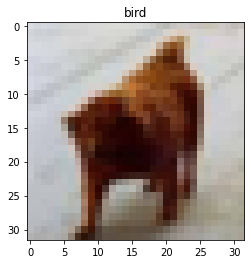

In [40]:
with torch.no_grad():
    choice = np.random.randint(0,len(TESTDATASETS))
    inputs,target = TESTDATASETS[choice]
    inputs = torch.as_tensor( np.array( [inputs.numpy()]) )
    inputs = inputs.to(DEVICE)
    outputs = model(inputs)
    print(outputs)
    _,predict = torch.max(outputs.data,dim=1)
    plt.title(CLASSES[predict])
    plt.imshow(np.transpose( inputs.to("cpu").numpy()[0],(1,2,0)))
    print( CLASSES[target],':',(CLASSES[target] ==CLASSES[predict]) )